In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib notebook

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

One of the issues with using the station data to calculate load is the station's downtime. Since the slough is tidally influenced, tidal height data from NOAA station 9413450 was used to model discharge during periods when ADCP data was unavailable. Rain data from the Moss Landing weather station was used to model changes in discharge due to rain. All data was collected at 20-minute intervals to match the frequency of the monitoring station.


In [2]:
#set files as dataframes

morocojo_file = 'C:/moro_2023.csv'
rain_file = 'C:/rain_2023.csv'
tide_file = 'C:/tides2023.csv'
df_moro = pd.read_csv(morocojo_file)
df_rain = pd.read_csv(rain_file)
df_tide = pd.read_csv(tide_file)


In [3]:
#then check for correct date format

df_moro['timestamp'] = pd.to_datetime(df_moro['utc_time'], utc=True, format = 'mixed')
df_moro.set_index('timestamp', inplace=True)

df_rain['timestamp'] = pd.to_datetime(df_rain['utc_time'], utc=True, format = 'mixed')
df_rain.set_index('timestamp', inplace=True)

df_tide['timestamp'] = pd.to_datetime(df_tide['Date Time'], utc=True, format = 'mixed')
df_tide.set_index('timestamp', inplace=True)

The rain data is cumulative per day. The cell below calculates the real-time rainfall.

In [4]:
# Calculate the difference between consecutive rows to get the real-time rain data per timestamp
diff_rain = df_rain['rain'].diff()

# Clip the result to ensure non-negative differences
real_time_rain = diff_rain.clip(lower=0).fillna(df_rain['rain'])

# Add the real-time rain data to the DataFrame
df_rain['real_rain'] = real_time_rain

# Save the result to a CSV file if you want to verify
#df_rain.to_csv('C:/Users/009855027/Documents/Model/real_time_rain.csv', header=True)

In [5]:
#resample for every 20 min to ensure that all data is at the same frequency

#discharge and nitrate are already in 20min intervals so the mean is chosen 
df_moro_resamp = df_moro[['total_discharge','nitrogen_mg']].resample('20T').mean()

# rain data is for every minute, we want the sum/ 20 min
df_rain_resamp = df_rain['real_rain'].resample('20T').sum().to_frame(name='rain2')

# to make sure NOAA tide data is in the same format
df_tide_resamp = df_tide['Water Level'].resample('20T').mean().to_frame(name='tide')


In [6]:
# merge the DFs on timestamp 

merged_df = df_tide_resamp.merge(df_moro_resamp, on='timestamp', how='outer')
#print(merged_df)
merged_df = merged_df.merge(df_rain_resamp, on='timestamp', how='outer')
#print(merged_df)

From this point on, care must be taken. The data should be reviewed for outliers or trends that might affect the model, as well as for identifying any data gaps.

<IPython.core.display.Javascript object>


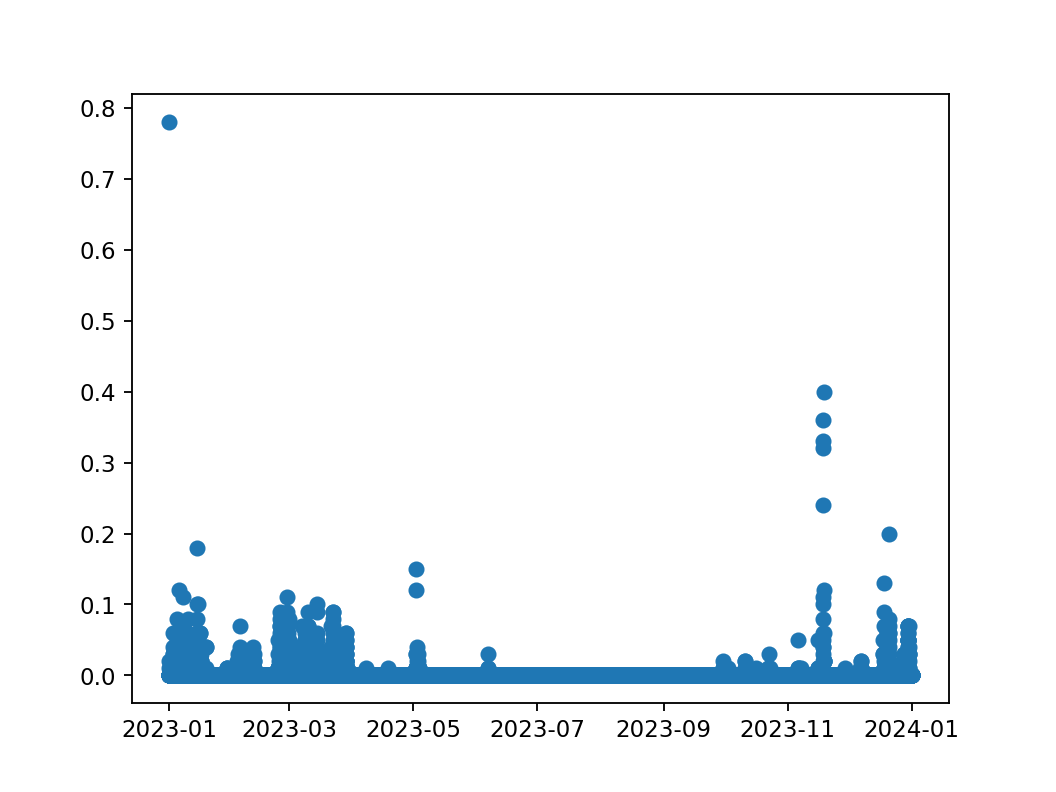

In [7]:
#plot rain data
plt.scatter(df_rain_resamp.index,df_rain_resamp.rain2)
plt.show()

<IPython.core.display.Javascript object>


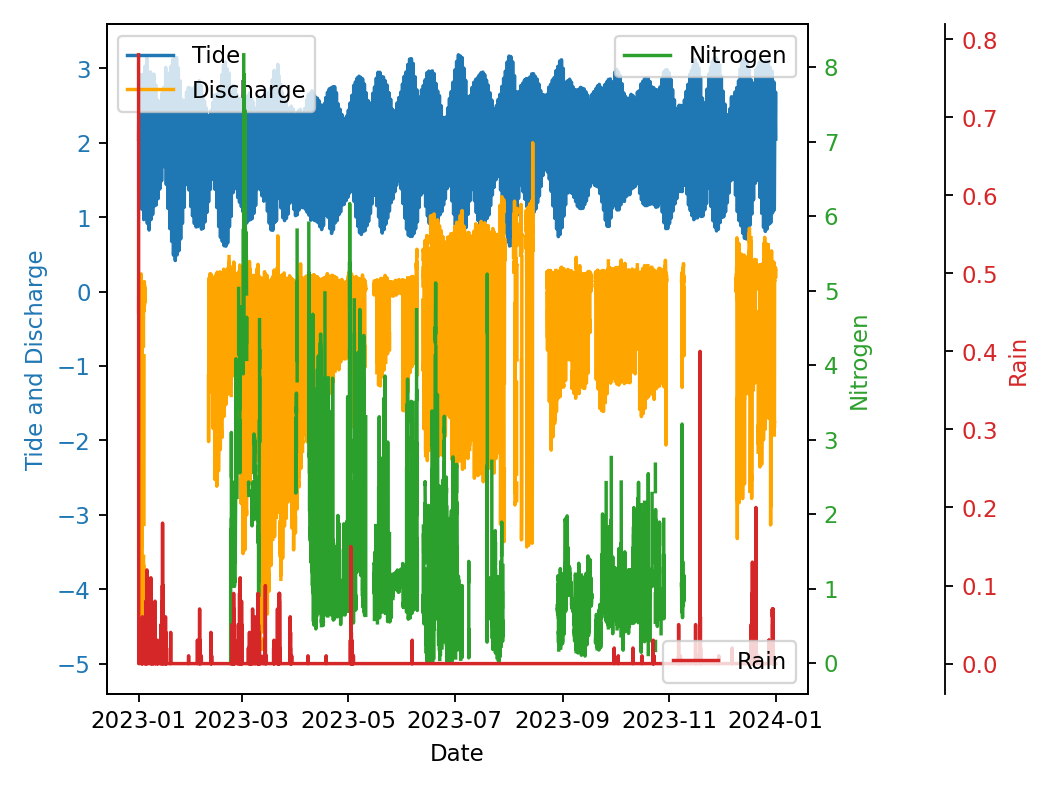

In [12]:
#plot all data and look for gaps. Look for and note, 
#large trends and zoom in for finer resolution patterns

# change to arrays 
date = merged_df.index 
nitrogen = merged_df.nitrogen_mg.values
tide = merged_df.tide.values
discharge = merged_df.total_discharge.values
rain = merged_df.rain2.values

fig, ax1 = plt.subplots()

# Plotting tide and discharge on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Tide and Discharge', color=color)
ax1.plot(date, tide, color=color, label='Tide')
ax1.plot(date, discharge, color='orange', label='Discharge')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Creating a second y-axis for nitrogen
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Nitrogen', color=color)
ax2.plot(date, nitrogen, color=color, label='Nitrogen')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Creating a third y-axis for rain
ax3 = ax1.twinx()
color = 'tab:red'
ax3.spines['right'].set_position(('outward', 60))  # Adjust the position of the third y-axis
ax3.set_ylabel('Rain', color=color)
ax3.plot(date, rain, color=color, label='Rain')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='lower right')

plt.tight_layout()
plt.show()

From here, you need to identify bad and good data. There are periods where the ADCP data appears inaccurate. Remove the bad data and select a section of good data to train your model. In years of heavy rainfall, consider breaking the analysis into seasons. Remember, the main goal is to fill data gaps. If more data gaps occur in the dry season, train your model using dry season data.

In [10]:
# check for bad data and remove outliers in discharge data 

merged_df = merged_df.drop(merged_df[(merged_df['total_discharge'] < -5) | (merged_df['total_discharge'] > 2)].index)

<IPython.core.display.Javascript object>


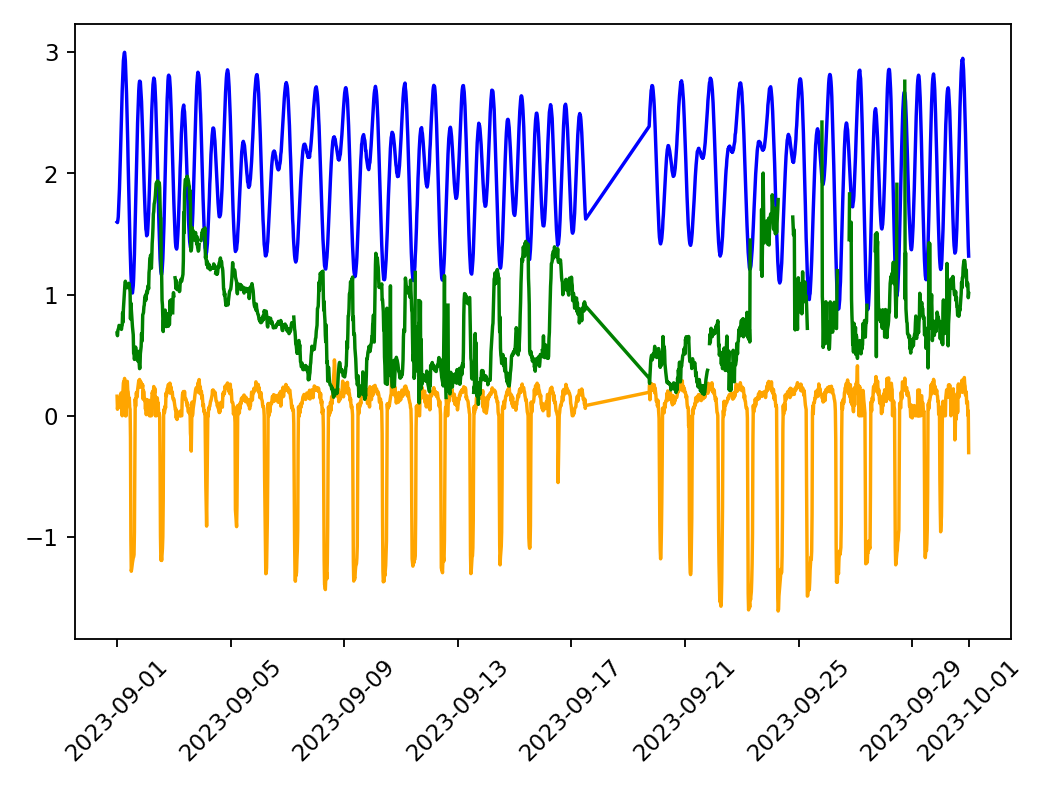

In [18]:
#here we are selecting clean data to train the model with outliers removed

start_date = '2023-09-01'
end_date = '2023-09-30'
trimmed_df = merged_df[start_date:end_date]
trimmed_df = trimmed_df[trimmed_df['total_discharge']>-5]
trimmed_df = trimmed_df[trimmed_df['total_discharge']<3]
trimmed_df = trimmed_df.dropna(subset=['total_discharge', 'rain2'])





plt.plot(trimmed_df.index,trimmed_df.tide.values, color='b')
plt.plot(trimmed_df.index,trimmed_df.total_discharge.values, color='orange')
plt.plot(trimmed_df.index,trimmed_df.nitrogen_mg.values, color='g')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

After running various models to capture this tide-discharge relationship, I concluded that a random forest regressor performed the best.

In [19]:
#train and evaluate the model 
# Select features and target variable
features = ['tide', 'rain2']
target = 'total_discharge'

# Reshape the features to a 2D array
X = trimmed_df[features].values
y = trimmed_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.048457939815880285


If you are happy with the model results then create a new column and fill it with the predicted data. Then plot the actual and predicted discharge to verify.  

In [20]:
# Create a new column 'predicted_total_discharge' and fill it with NaN

final_df = merged_df

final_df['predicted_total_discharge'] = float('nan')

# Reshape the features to a 2D array
imputer = SimpleImputer(strategy='mean')
final_df[features] = imputer.fit_transform(final_df[features])

X_final = final_df[features].values

# Make predictions on new data
predictions_final = model.predict(X_final)

# Assign the predicted values to the new column
final_df['predicted_total_discharge'] = predictions_final

<IPython.core.display.Javascript object>


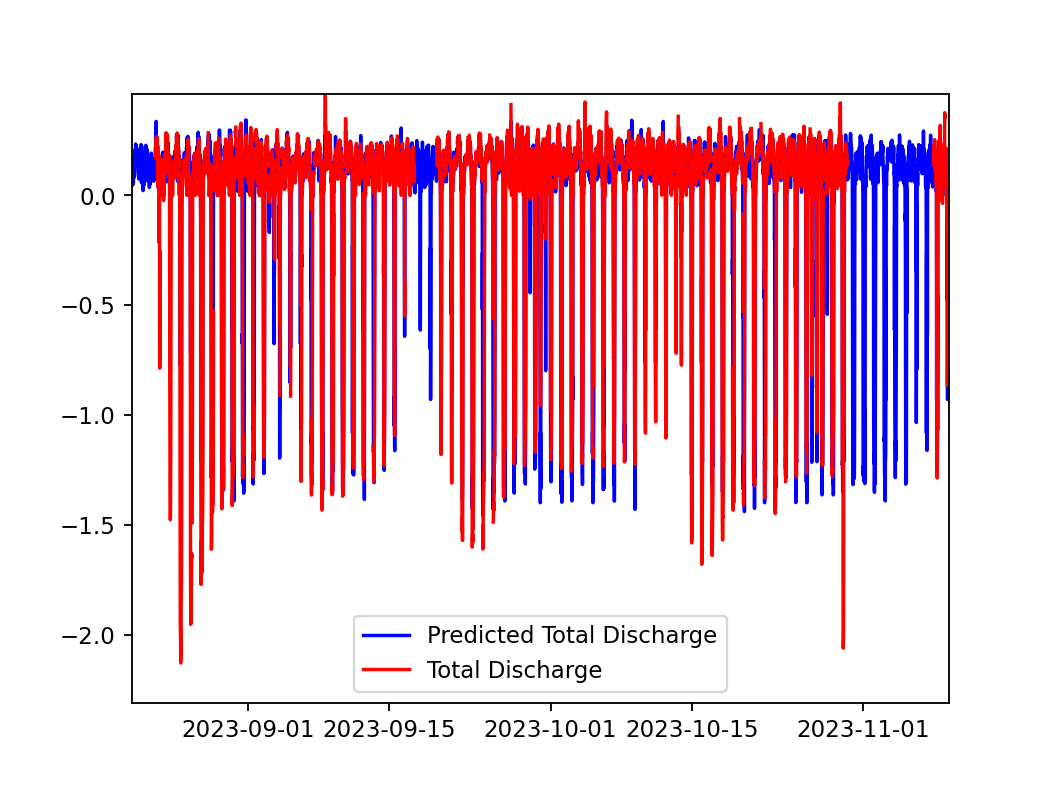

In [22]:
# Plotting predicted discharge to measured to see if patterns hold true 
plt.plot(final_df.index, final_df['predicted_total_discharge'], color='b', label='Predicted Total Discharge')
plt.plot(final_df.index, final_df['total_discharge'], color='r', label='Total Discharge')

# Add legend
plt.legend()
#plt.plot(final_df.index, final_df['nitrogen_mg'])

In [23]:
# now fill gaps in measured flow with predicted. 

final_df['filled_flow'] = final_df['total_discharge'].fillna(final_df['predicted_total_discharge'])

Now that we have filled the missing discharge values with our predictions, the next and final step is to validate and adjust the nitrate values. When nitrate and discharge were plotted, it became evident that higher nitrate values were observed when there was no discharge. We hypothesized that a nearby waterway with higher nitrate concentration enters the system during rising tides. Therefore, the most representative nitrate data for Moro Cojo occurs when the tide is at a minimum and discharge is near its daily maximum value.

The subsequent steps involve identifying daily low tides and using nitrate data only from those events. We will then employ a temporal spline to fill in any remaining gaps in the nitrate data.

In [24]:
# now lets identify min flows "max discharge" by tide data and spline the nitrate 

min_tide_index = final_df.groupby(final_df.index.date)['tide'].idxmin()

final_df['tide_min']=''
final_df.loc[final_df.index.isin(min_tide_index),'tide_min']='min'

min_tide_rows = final_df['tide_min'] =='min'


In [25]:
#we need to make a new row for true nitrogen
#min_index = final_df.index[final_df['tide_min']=='min'].tolist()
final_df['discharge_N'] =''

for index, row in final_df.iterrows():
    if row['tide_min'] =='min' and pd.notna(row['nitrogen_mg']):
        final_df.at[index, 'discharge_N'] = row['nitrogen_mg']
    else:
        pass


<IPython.core.display.Javascript object>


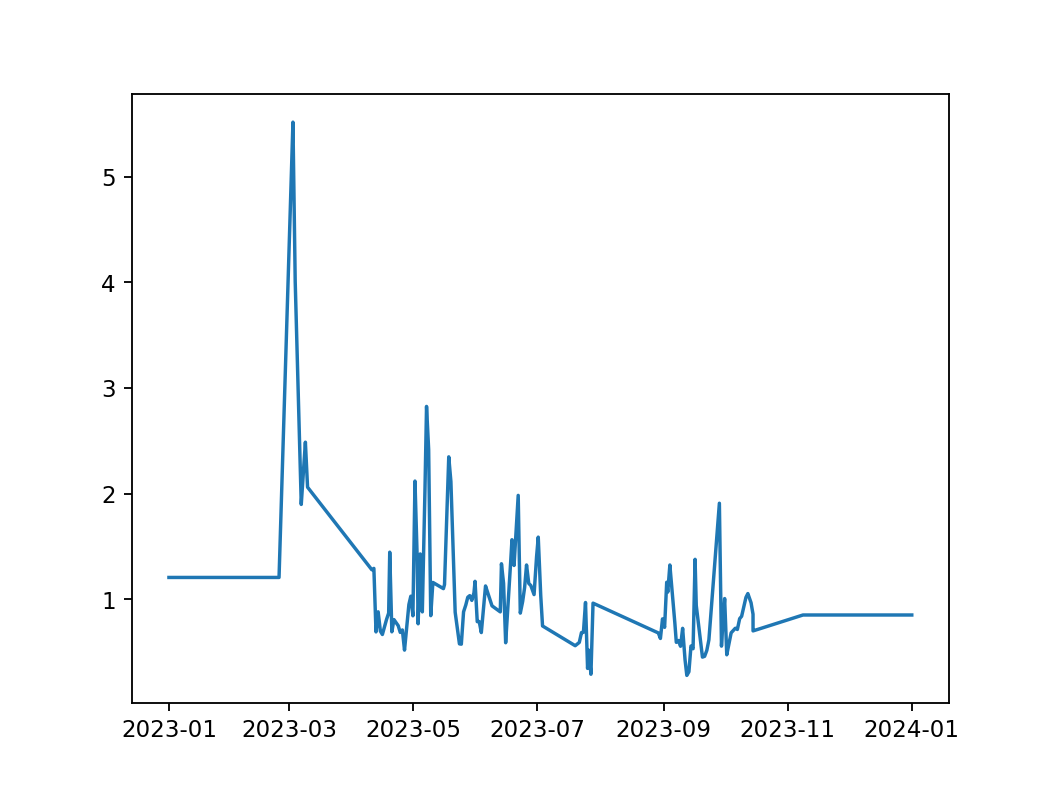

In [26]:

final_df['discharge_N'] = pd.to_numeric(final_df['discharge_N'], errors='coerce')


# Fill missing values with linear interpolation
final_df['filled_discharge_N_linear'] = final_df['discharge_N'].interpolate(method='time', limit_direction='both')

# Display the DataFrame
plt.plot(final_df.index,final_df['filled_discharge_N_linear'])

In [242]:
#change discharge from m^3/s to L/20 min and multiply by nitrogen to get load
final_df['load kg/L'] = (final_df['filled_flow']*1200*1000*final_df['filled_discharge_N_linear'])/1000000*(-1)


#calculate the sum of N (mg/yr)
N_flux_sum = final_df['load kg/L'].sum()


print(f' Total = {N_flux_sum} kg nitrate-N/ year')


 Total = 6189.216253071151 kg nitrate-N/ year


<IPython.core.display.Javascript object>


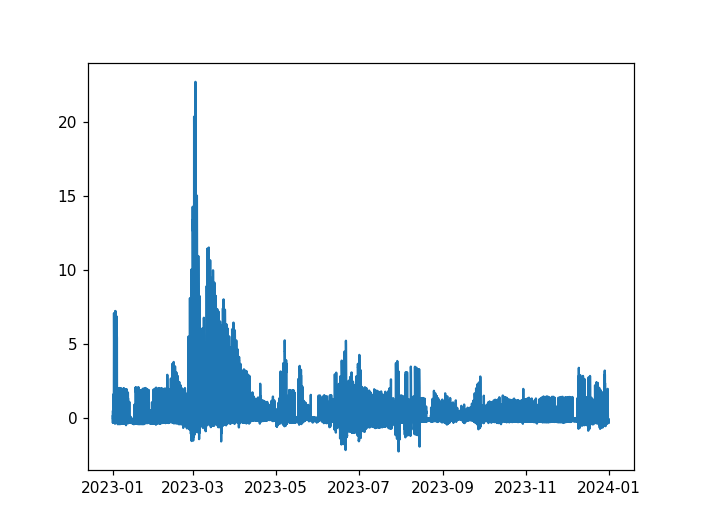

<function matplotlib.pyplot.show(*, block=None)>

In [243]:
#plot load
plt.plot(final_df.index,final_df['load kg/L'])
plt.show

In [244]:
#For reporting, calculate loads and SD for each month

monthly_df = final_df.resample('M').agg({'load kg/L': ['sum', 'std']}).bfill()

print(monthly_df)




                             load kg/L          
                                   sum       std
timestamp                                       
2023-01-31 00:00:00+00:00   468.554932  1.090984
2023-02-28 00:00:00+00:00   755.187611  1.644877
2023-03-31 00:00:00+00:00  3783.548849  3.649025
2023-04-30 00:00:00+00:00   578.750881  0.915076
2023-05-31 00:00:00+00:00   216.373533  0.718449
2023-06-30 00:00:00+00:00     4.570744  1.134442
2023-07-31 00:00:00+00:00    22.488932  0.953181
2023-08-31 00:00:00+00:00    86.814111  0.815359
2023-09-30 00:00:00+00:00     7.406774  0.457743
2023-10-31 00:00:00+00:00    18.347705  0.411746
2023-11-30 00:00:00+00:00    92.037879  0.476925
2023-12-31 00:00:00+00:00   155.134302  0.682059


<IPython.core.display.Javascript object>


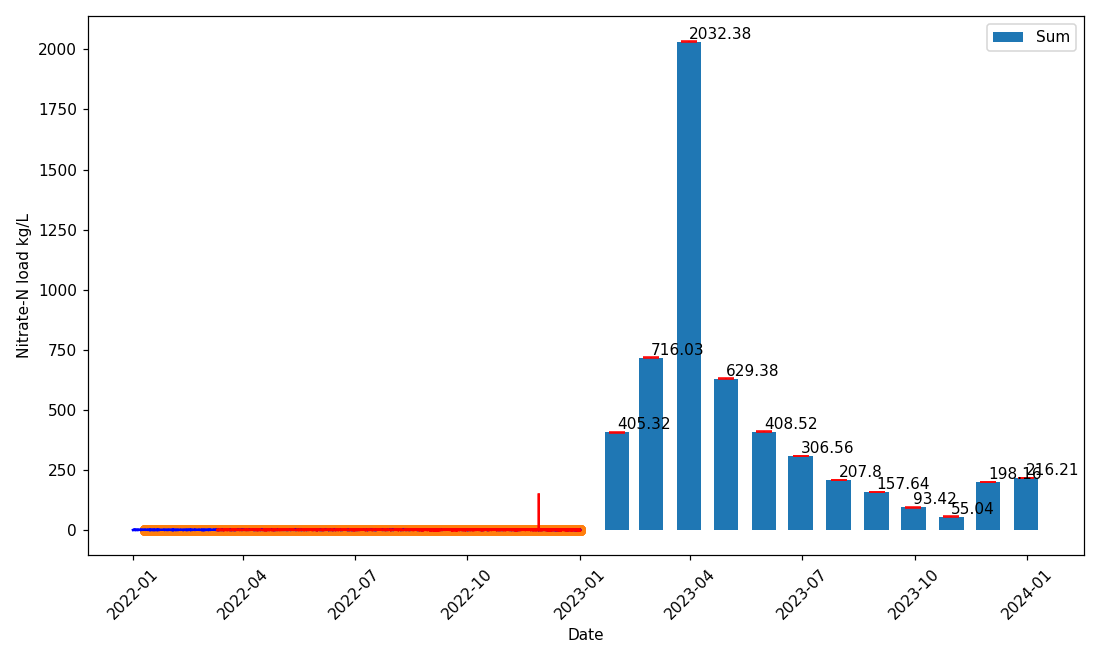

In [21]:

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plotting the bar graph for the sum
bars = plt.bar(monthly_df.index, monthly_df['load kg/L', 'sum'], width=20, label='Sum')  # Adjust width as needed

# Adding error bars for the standard deviation
plt.errorbar(monthly_df.index, monthly_df['load kg/L', 'sum'], yerr=monthly_df['load kg/L', 'std'], fmt='none', ecolor='red', capsize=5)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Nitrate-N load kg/L')
#plt.title('Filled Discharge (N linear) Sum and Standard Deviation over Time')

# Rotating x-axis labels for better readability (if needed)
plt.xticks(rotation=45)

# Adding the bar values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

# Display the plot
plt.legend()
plt.tight_layout()  # Adjust layout
plt.show()